# DS-FT10 GROUP 3 Phase II Project 

# Importing Necessary Libraries

In [262]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import gzip
import io
import calendar
import tempfile
import os

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, probplot

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Data Staging

In [263]:
##Read from zipped db file
def read_db_from_zip(zip_file_path, db_file_name, query):
    """Reads a SQLite database file directly from a zip archive and returns a DataFrame."""
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        with zip_ref.open(db_file_name) as file:
            # Create a temporary file to store the database
            with tempfile.NamedTemporaryFile(delete=False) as temp_file:
                temp_file.write(file.read())
                temp_file_path = temp_file.name  # Store the path to the temp file

            # Create a connection to the temporary database
            conn = sqlite3.connect(temp_file_path)
            # Execute the query and return a DataFrame
            df = pd.read_sql_query(query, conn)
            conn.close()

            # Optionally, remove the temporary file manually after use
            os.remove(temp_file_path)
            
            return df



In [264]:
## Read from zipped csv files

def read_csv_gz(file_path):
    """Reads a gzipped CSV file and returns a DataFrame."""
    df = pd.read_csv(file_path, compression='gzip')
    return df

In [265]:
im_df = read_db_from_zip('./zippedData/im.db.zip', 'im.db', 'SELECT * FROM movie_basics')
bom = read_csv_gz('./zippedData/bom.movie_gross.csv.gz')
tmdb_movies = read_csv_gz('./zippedData/tmdb.movies.csv.gz')
tn_movies_b = read_csv_gz('./zippedData/tn.movie_budgets.csv.gz')

# Data Cleaning

#### Data Cleaning Procedure:
- Dropping columns
- Removing Duplicates
- Merging DataFrames
- Dropping Columns after merge
- Dropping null values
- Dropping duplicates after merge

In [266]:
# Drop Year
bom = bom.drop('year', axis=1)

In [267]:
# Drop original_title, start_year, and movie_id columns
columns_dropping = ['original_title', 'start_year', 'movie_id']
im_df = im_df.drop(columns=columns_dropping)

In [268]:
# Unnamed, genre_ids,original_title, id
column_dropping = ['genre_ids', 'id', 'original_title']
tmdb_movies = tmdb_movies.drop(columns=column_dropping)

In [269]:
tn_movies_b['movie'].nunique()

5698

In [270]:
# Identify duplicate movies in the 'movie' column
duplicate_movies = tn_movies_b[tn_movies_b['movie'].duplicated()]

# duplicate_movies.head()


In [271]:
# Group by the 'movie' column and count occurrences, then filter for duplicates
duplicate_movie_counts = tn_movies_b['movie'].value_counts()
duplicate_movie_counts = duplicate_movie_counts[duplicate_movie_counts > 1]

# duplicate_movie_counts

In [272]:
# Filter rows where the movie name is 'Godzilla'
godzilla_movies = tn_movies_b[tn_movies_b['movie'] == 'Halloween']

# godzilla_movies

In [273]:
# Perform an inner join on the title columns
merged_df = pd.merge(bom, im_df, left_on='title', right_on='primary_title', how='inner')
merged_df2 = pd.merge(merged_df, tmdb_movies, left_on='title', right_on='title', how='inner')
merged_df3 = pd.merge(merged_df2, tn_movies_b, left_on='title', right_on='movie', how='inner')

# Display the first few rows of the merged DataFrame
# merged_df3.head()

In [274]:
merged_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              2097 non-null   object 
 1   studio             2097 non-null   object 
 2   domestic_gross_x   2096 non-null   float64
 3   foreign_gross      1751 non-null   object 
 4   primary_title      2097 non-null   object 
 5   runtime_minutes    1959 non-null   float64
 6   genres             2057 non-null   object 
 7   Unnamed: 0         2097 non-null   int64  
 8   original_language  2097 non-null   object 
 9   popularity         2097 non-null   float64
 10  release_date_x     2097 non-null   object 
 11  vote_average       2097 non-null   float64
 12  vote_count         2097 non-null   int64  
 13  id                 2097 non-null   int64  
 14  release_date_y     2097 non-null   object 
 15  movie              2097 non-null   object 
 16  production_budget  2097 

In [275]:
column_dropping = ['primary_title', 'foreign_gross', 'original_language', 'release_date_y', 'domestic_gross_x']
merged_df3 = merged_df3.drop(columns = column_dropping)
# merged_df3.head()

In [276]:
# Drop rows with any missing values

merged_df3.dropna(inplace=True)


In [277]:
# Droping the Duplicates
merged_df3.drop_duplicates(inplace=True)

In [278]:
merged_df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1950 entries, 0 to 2096
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1950 non-null   object 
 1   studio             1950 non-null   object 
 2   runtime_minutes    1950 non-null   float64
 3   genres             1950 non-null   object 
 4   Unnamed: 0         1950 non-null   int64  
 5   popularity         1950 non-null   float64
 6   release_date_x     1950 non-null   object 
 7   vote_average       1950 non-null   float64
 8   vote_count         1950 non-null   int64  
 9   id                 1950 non-null   int64  
 10  movie              1950 non-null   object 
 11  production_budget  1950 non-null   object 
 12  domestic_gross_y   1950 non-null   object 
 13  worldwide_gross    1950 non-null   object 
dtypes: float64(3), int64(3), object(8)
memory usage: 228.5+ KB


# Statistical Analysis

In [279]:
df = merged_df3.copy()

In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1950 entries, 0 to 2096
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1950 non-null   object 
 1   studio             1950 non-null   object 
 2   runtime_minutes    1950 non-null   float64
 3   genres             1950 non-null   object 
 4   Unnamed: 0         1950 non-null   int64  
 5   popularity         1950 non-null   float64
 6   release_date_x     1950 non-null   object 
 7   vote_average       1950 non-null   float64
 8   vote_count         1950 non-null   int64  
 9   id                 1950 non-null   int64  
 10  movie              1950 non-null   object 
 11  production_budget  1950 non-null   object 
 12  domestic_gross_y   1950 non-null   object 
 13  worldwide_gross    1950 non-null   object 
dtypes: float64(3), int64(3), object(8)
memory usage: 228.5+ KB


In [281]:
# Removing currency symbols and commas, then converting to numeric
df['production_budget'] = df['production_budget'].replace('[\$,]', '', regex=True).astype(float)
df['domestic_gross_y'] = df['domestic_gross_y'].replace('[\$,]', '', regex=True).astype(float)
df['worldwide_gross'] = df['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)

In [282]:
df.describe()

,runtime_minutes,Unnamed: 0,popularity,vote_average,vote_count,id,production_budget,domestic_gross_y,worldwide_gross
count,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1.950000e+03,1.950000e+03,1.950000e+03
mean,103.541538,11706.529744,11.839029,6.306974,1976.818974,52.261538,4.327249e+07,5.729225e+07,1.407568e+08
std,24.531946,7595.575775,8.045981,1.092224,2779.357534,28.568844,5.382722e+07,8.430301e+07,2.256960e+08
min,3.000000,1.000000,0.600000,0.000000,1.000000,1.000000,5.000000e+04,0.000000e+00,0.000000e+00
25%,91.000000,5244.500000,7.572500,5.800000,248.250000,28.000000,9.000000e+06,4.463292e+06,1.478114e+07
50%,103.000000,11240.000000,10.468500,6.300000,955.000000,52.000000,2.500000e+07,3.082463e+07,5.916869e+07
75%,117.000000,17580.000000,14.988000,6.900000,2421.000000,76.000000,5.000000e+07,7.045886e+07,1.599465e+08
max,192.000000,26506.000000,80.773000,10.000000,22186.000000,100.000000,4.106000e+08,7.000596e+08,2.048134e+09


In [283]:
df.corr(numeric_only=True)

,runtime_minutes,Unnamed: 0,popularity,vote_average,vote_count,id,production_budget,domestic_gross_y,worldwide_gross
runtime_minutes,1.000000,0.034445,0.234737,0.203221,0.243246,-0.034692,0.206975,0.158561,0.183040
Unnamed: 0,0.034445,1.000000,0.209186,0.043354,0.058468,0.083961,-0.000430,0.036036,0.042675
popularity,0.234737,0.209186,1.000000,0.297873,0.689630,-0.038839,0.528969,0.491746,0.533334
vote_average,0.203221,0.043354,0.297873,1.000000,0.352144,-0.026904,0.072752,0.166523,0.168417
vote_count,0.243246,0.058468,0.689630,0.352144,1.000000,-0.025566,0.564770,0.691936,0.710847
id,-0.034692,0.083961,-0.038839,-0.026904,-0.025566,1.000000,-0.097524,-0.009605,-0.032612
production_budget,0.206975,-0.000430,0.528969,0.072752,0.564770,-0.097524,1.000000,0.691730,0.770965
domestic_gross_y,0.158561,0.036036,0.491746,0.166523,0.691936,-0.009605,0.691730,1.000000,0.944169
worldwide_gross,0.183040,0.042675,0.533334,0.168417,0.710847,-0.032612,0.770965,0.944169,1.000000


In [284]:
# Set figure size to make the plot larger
plt.figure(figsize=(10, 8))

# Plotting the correlation heatmap
# dataplot = sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)

# Displaying heatmap
# plt.show()

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [285]:
df_numeric = df.select_dtypes(include = ['number'])
df_numeric.corr()

,runtime_minutes,Unnamed: 0,popularity,vote_average,vote_count,id,production_budget,domestic_gross_y,worldwide_gross
runtime_minutes,1.000000,0.034445,0.234737,0.203221,0.243246,-0.034692,0.206975,0.158561,0.183040
Unnamed: 0,0.034445,1.000000,0.209186,0.043354,0.058468,0.083961,-0.000430,0.036036,0.042675
popularity,0.234737,0.209186,1.000000,0.297873,0.689630,-0.038839,0.528969,0.491746,0.533334
vote_average,0.203221,0.043354,0.297873,1.000000,0.352144,-0.026904,0.072752,0.166523,0.168417
vote_count,0.243246,0.058468,0.689630,0.352144,1.000000,-0.025566,0.564770,0.691936,0.710847
id,-0.034692,0.083961,-0.038839,-0.026904,-0.025566,1.000000,-0.097524,-0.009605,-0.032612
production_budget,0.206975,-0.000430,0.528969,0.072752,0.564770,-0.097524,1.000000,0.691730,0.770965
domestic_gross_y,0.158561,0.036036,0.491746,0.166523,0.691936,-0.009605,0.691730,1.000000,0.944169
worldwide_gross,0.183040,0.042675,0.533334,0.168417,0.710847,-0.032612,0.770965,0.944169,1.000000


In [286]:
plt.figure(figsize = (10,6))

# sns.regplot(data=df,x='domestic_gross_y',y='worldwide_gross')
# plt.title('ScatterPlot on Correlation')

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [287]:
# Scatter plot for the budget against worlwide gross
plt.figure(figsize=(10,8))
# sns.regplot(data=df,x='production_budget',y='worldwide_gross')
# plt.grid()

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

# EDA

In [288]:
# df['genres'].unique()

In [289]:
# Split genres by comma, stack into a single column, and count each genre
genre_counts = df['genres'].str.split(',').explode().value_counts()

# Display the result
# print(genre_counts)


In [290]:
listofgenre = df.loc[:,['genres']]

In [291]:
gen = listofgenre.stack().to_list()

In [292]:
from collections import defaultdict

# Step 1: Initialize a dictionary to hold genre counts
genre_counts = defaultdict(int)

# Step 2: Loop through each genre string, split it, and count each genre
for genres in gen:
    # Split the genres and strip any extra whitespace
    individual_genres = genres.split(',')
    for genre in individual_genres:
        genre = genre.strip()  # Ensure no leading/trailing whitespace
        genre_counts[genre] += 1

# Convert the defaultdict to a regular dictionary (optional)
genre_counts = dict(genre_counts)

# Display the result
print(genre_counts)

{'Adventure': 367, 'Animation': 112, 'Comedy': 550, 'Action': 471, 'Sci-Fi': 131, 'Drama': 1007, 'Fantasy': 129, 'Family': 95, 'Thriller': 332, 'History': 73, 'Romance': 229, 'Horror': 225, 'Mystery': 145, 'Western': 8, 'Biography': 192, 'Documentary': 137, 'Crime': 255, 'Sport': 45, 'War': 15, 'Music': 55, 'Musical': 6, 'News': 2}


In [293]:
# # Convert dictionary keys and values to lists for plotting
# genres = list(genre_counts.keys())
# counts = list(genre_counts.values())

# # Bar plot for genre counts
# plt.figure(figsize=(12, 6))
# # plt.bar(genres, counts, color='blue')
# plt.xlabel('Number of Movies')
# plt.ylabel('Genres')
# plt.title('Distribution of Movie Genres')
# plt.xticks(rotation=45)
# # plt.show()

In [294]:
# Initialize a dictionary to hold lists of titles for each genre
genre_movies = defaultdict(list)

# Loop through each row in the DataFrame
for _, row in df.iterrows():
    # Split the genres in the current row
    row_genres = row["genres"].split(',')
    for genre in row_genres:
        genre = genre.strip()  # Remove any extra whitespace
        # Check if the genre exists in genre_counts and add the title to genre_movies
        if genre in genre_counts:
            genre_movies[genre].append(row["title"])

# Convert the defaultdict to a regular dictionary (optional)
genre_movies = dict(genre_movies)

# Display the result
# print(genre_movies)

In [295]:
genre_movies.keys()

dict_keys(['Adventure', 'Animation', 'Comedy', 'Action', 'Sci-Fi', 'Drama', 'Fantasy', 'Family', 'Thriller', 'History', 'Romance', 'Horror', 'Mystery', 'Western', 'Biography', 'Documentary', 'Crime', 'Sport', 'War', 'Music', 'Musical', 'News'])

In [296]:
genrate = []
for key, value in genre_movies.items():
    movies = genre_movies.get(key, [])
    movies = pd.Series(movies)
    moviedata = df[df['title'].isin(movies)]
    # getting avg
    numeric_values = [float(value) for value in moviedata['vote_average']]
    avg = sum(numeric_values)/len(numeric_values)
    
    genrate.append({key:avg})
# genrate

In [297]:
# Ensure columns are NumPy arrays and calculate ROI
roi = df['worldwide_gross'].values / df['production_budget'].values

# Convert the result back to a pandas Series and add to DataFrame
df['roi'] = pd.Series(roi, index=df.index)


In [298]:
genroi = []
for key, value in genre_movies.items():
    movies = genre_movies.get(key, [])
    movies = pd.Series(movies)
    moviedata = df[df['title'].isin(movies)]
    # getting avg
    numeric_values = [float(value) for value in moviedata['roi']]
    avg = sum(numeric_values)/len(numeric_values)
    
    genroi.append({key:avg})

# genroi

In [299]:
genrevenue = []
for key, value in genre_movies.items():
    movies = genre_movies.get(key, [])
    movies = pd.Series(movies)
    moviedata = df[df['title'].isin(movies)]
    
    # Calculate the sum of worldwide_gross
    total_gross = moviedata['worldwide_gross'].sum()
    
    # Calculate the average, avoiding division by zero
    avg = total_gross / len(moviedata['worldwide_gross']) 
    
    genrevenue.append({key: avg})
# genrevenue

In [300]:
# Initialize a dictionary to combine values
combined_dict = {}

# Combine the first list of dictionaries
for entry in genrevenue:
    for key, value in entry.items():
        combined_dict[key] = [value]  # Start a new list for each genre

# Append the values from the second list of dictionaries
for entry in genrate:
    for key, value in entry.items():
        if key in combined_dict:
            combined_dict[key].append(value)  # Append to existing list

# Append the values from the third list of dictionaries
for entry in genroi:
    for key, value in entry.items():
        if key in combined_dict:
            combined_dict[key].append(value)  # Append to existing list

# Convert the combined dictionary into a DataFrame
combined_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in combined_dict.items()]))

# Transpose the DataFrame
transposed_df = combined_df.T

# Change column names
transposed_df.columns = ['genre_avg_gross', 'gen_avg_rating', 'gen_avg_roi']  # Assign new column names

# Optionally, reset the index to make the genre names a column
transposed_df.reset_index(inplace=True)

# Rename the index column for clarity
transposed_df.rename(columns={'index': 'Genre'}, inplace=True)

# Display the transposed DataFrame
# transposed_df.to_csv('./genreAnalysis.csv')

# To be used in data visualization
# transposed_df

In [301]:
# # Plotting
# plt.figure(figsize=(12, 6))
# plt.bar(transposed_df['Genre'], transposed_df['gen_avg_roi'], color='blue')
# plt.title('Average ROI by Genre')
# plt.xlabel('Genre')
# plt.ylabel('Average ROI')
# plt.xticks(rotation=45)
# plt.grid(axis='y')
# # plt.show()

Text(0.5, 1.0, 'Boxplot of the Production Budget')

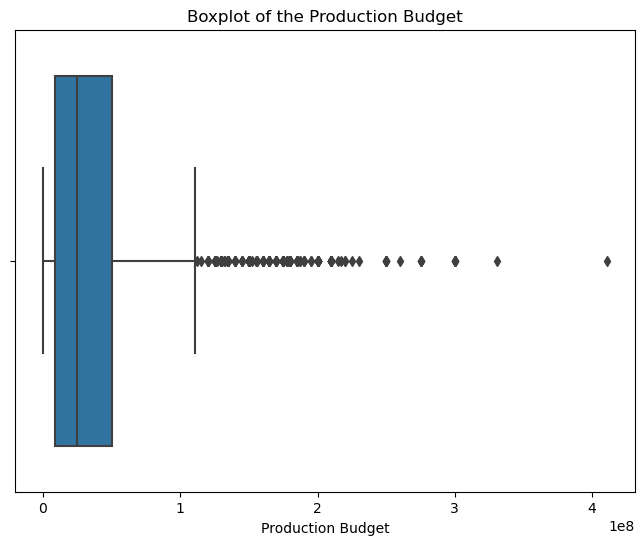

In [302]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='production_budget')
plt.xlabel('Production Budget')
plt.title('Boxplot of the Production Budget')
# plt.show()

Text(0.5, 1.0, 'Distribution of the Runtime Minutes')

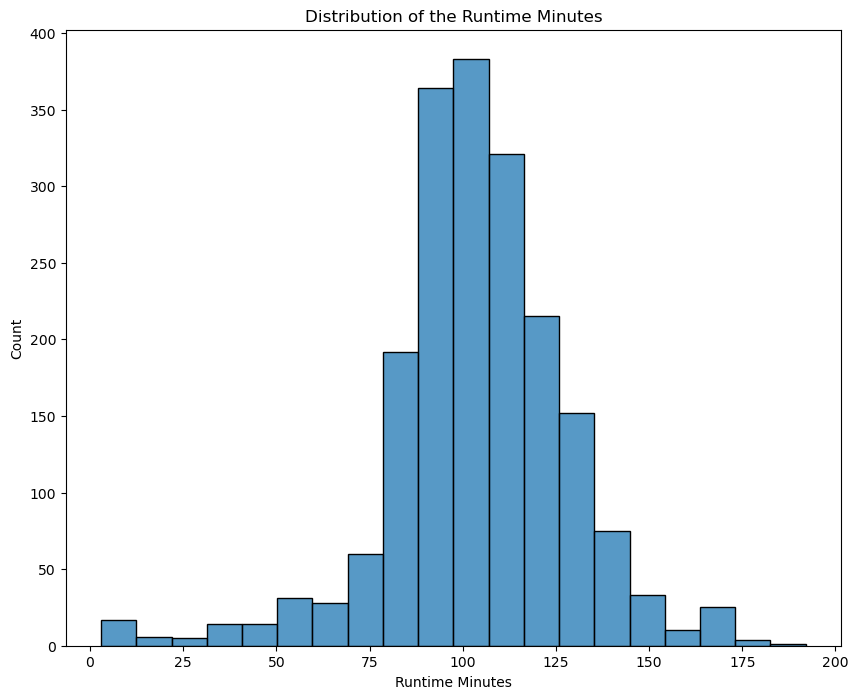

In [303]:
plt.figure(figsize=(10,8))
sns.histplot(data=df,x='runtime_minutes',bins=20)
plt.xlabel('Runtime Minutes')
plt.title('Distribution of the Runtime Minutes')

Text(0.5, 1.0, 'Distribution of the Worldwide gross')

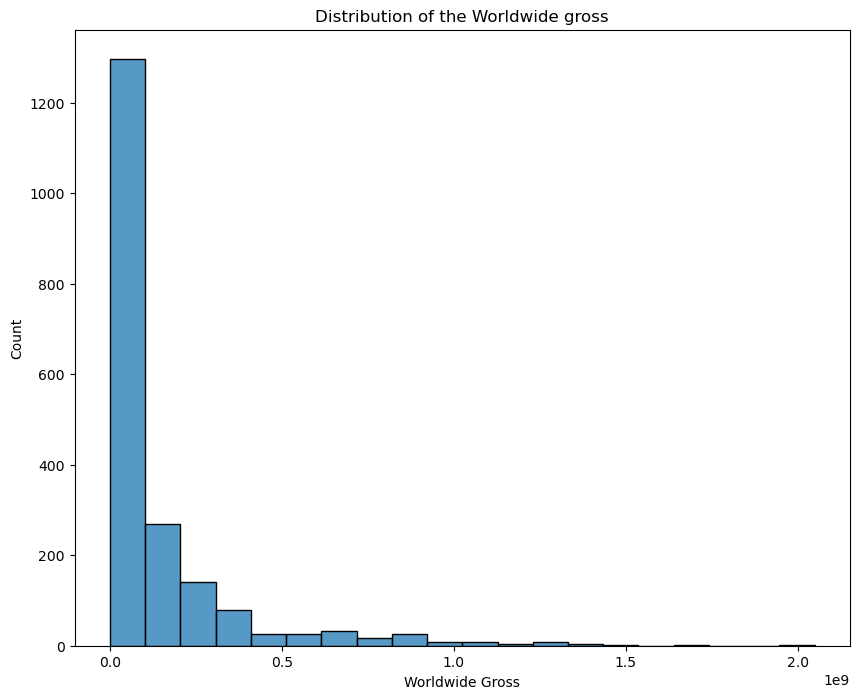

In [304]:
plt.figure(figsize=(10,8))
sns.histplot(data=df,x='worldwide_gross',bins=20)
plt.xlabel('Worldwide Gross')
plt.title('Distribution of the Worldwide gross')

In [305]:
# Created a year variable from the release date 
df['year'] = pd.to_datetime(df['release_date_x']).dt.year

In [306]:
# budgets and revenue ,vote_count average rating
filter_data = df[df['year']>=2010]

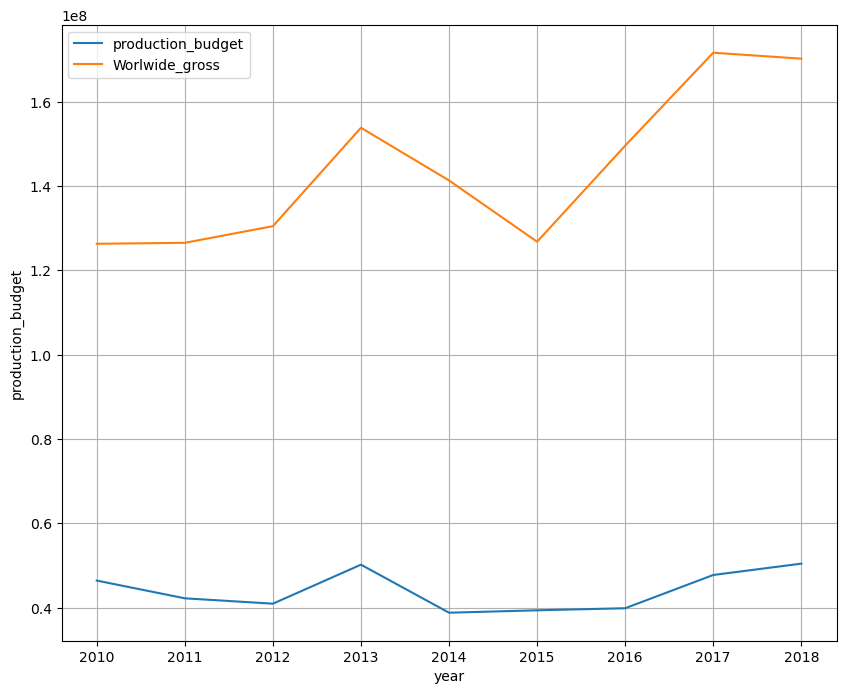

In [307]:
plt.figure(figsize=(10,8))
sns.lineplot(data=filter_data,x='year',y='production_budget',label='production_budget',ci=None)
sns.lineplot(data=filter_data,x='year',y='worldwide_gross',label='Worlwide_gross',ci=None)
# sns.lineplot()
plt.grid()

In [308]:
df['release_date_x'] = pd.to_datetime(df['release_date_x'])
df['month'] = df['release_date_x'].dt.month

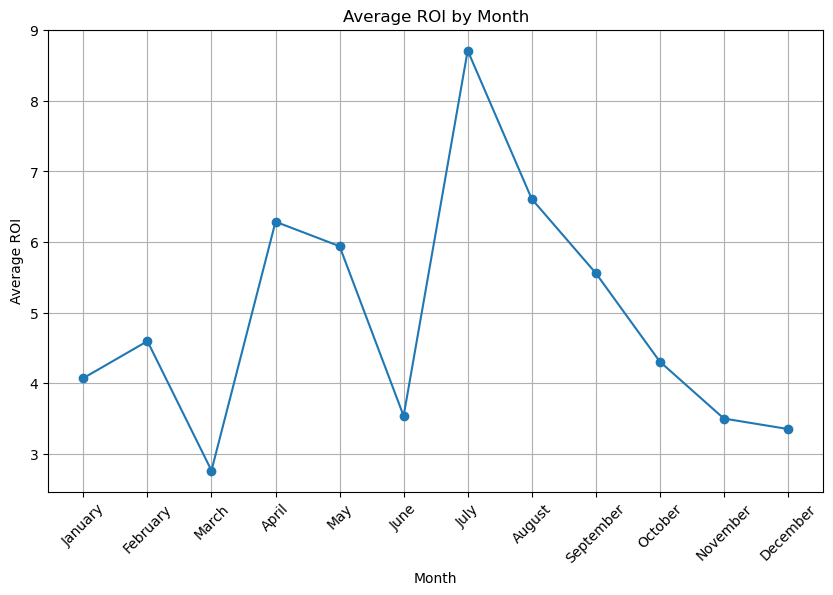

In [309]:
# Aggregate ROI by month (e.g., average ROI for each month)
monthly_roi = df.groupby('month')['roi'].mean().reset_index()

# Create a mapping of month numbers to month names
month_names = [calendar.month_name[i] for i in range(1, 13)]  # Full month names from January to December

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(monthly_roi['month'], monthly_roi['roi'], marker='o')
plt.title('Average ROI by Month')
plt.xlabel('Month')
plt.ylabel('Average ROI')
plt.xticks(monthly_roi['month'], month_names[:len(monthly_roi)], rotation=45)  # Change numbers to month names
plt.grid()
plt.show()

# Linear Regression

In [310]:
rstyle_model = smf.ols(formula="worldwide_gross ~ popularity + vote_average + vote_count + production_budget", data=df)
rstyle_results = rstyle_model.fit()

In [311]:
print(rstyle_results.summary())

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     1179.
Date:                Wed, 30 Oct 2024   Prob (F-statistic):               0.00
Time:                        11:33:08   Log-Likelihood:                -39074.
No. Observations:                1950   AIC:                         7.816e+04
Df Residuals:                    1945   BIC:                         7.819e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.678e+06   1.72e+0

In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1950 entries, 0 to 2096
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   title              1950 non-null   object        
 1   studio             1950 non-null   object        
 2   runtime_minutes    1950 non-null   float64       
 3   genres             1950 non-null   object        
 4   Unnamed: 0         1950 non-null   int64         
 5   popularity         1950 non-null   float64       
 6   release_date_x     1950 non-null   datetime64[ns]
 7   vote_average       1950 non-null   float64       
 8   vote_count         1950 non-null   int64         
 9   id                 1950 non-null   int64         
 10  movie              1950 non-null   object        
 11  production_budget  1950 non-null   float64       
 12  domestic_gross_y   1950 non-null   float64       
 13  worldwide_gross    1950 non-null   float64       
 14  roi          

In [313]:
# Fit the model
X = df[['popularity', 'vote_average', 'production_budget', 'domestic_gross_y']]
X = sm.add_constant(X)  # Add a constant term to the predictor
y = df['worldwide_gross']
model = sm.OLS(y, X).fit()

In [314]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        worldwide_gross   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     5536.
Date:                Wed, 30 Oct 2024   Prob (F-statistic):               0.00
Time:                        11:33:08   Log-Likelihood:                -37821.
No. Observations:                1950   AIC:                         7.565e+04
Df Residuals:                    1945   BIC:                         7.568e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4.602e+07   8.63e+06     -5.330      0.000    -6.3e+07   -2.91e+07
popularity         9.464e+05   2.27e+05      4.172      0.000    5.01e+05    1.39e+06
vote_average       2.767e+06   1.41e+06      1.962      0.050    1565.438    5.53e+06
production_budget     0.9009      0.040     22.724      0.000       0.823       0.979
domestic_gross_y      2.0794      0.025     84.725      0.000       2.031       2.128
==============================================================================
Omnibus:                     1019.842   Durbin-Watson:                   1.218
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21066.961
Skew:                           1.992   Prob(JB):                         0.00
Kurtosis:                      18.602   Cond. No.                     7.08e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.08e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

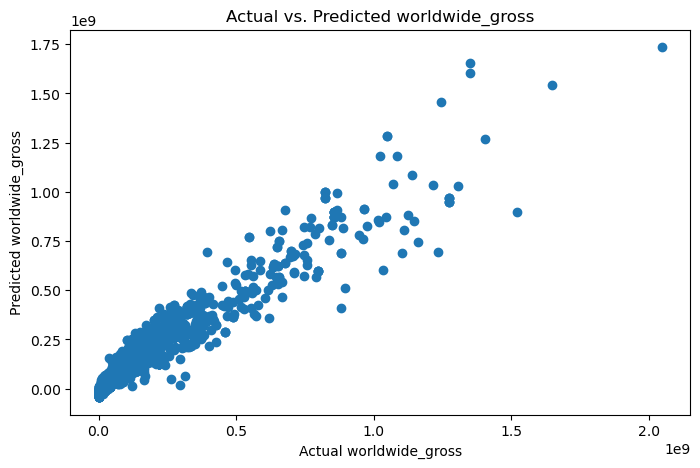

In [315]:
# 1. Linearity
# Plotting actual vs. predicted to check for linearity
plt.figure(figsize=(8, 5))
plt.scatter(y, model.predict(X))
plt.xlabel("Actual worldwide_gross")
plt.ylabel("Predicted worldwide_gross")
plt.title("Actual vs. Predicted worldwide_gross")
plt.show()

In [316]:
# 2. Independence of Errors (Durbin-Watson Test)
dw_test = durbin_watson(model.resid)
print(f'Durbin-Watson Test Statistic: {dw_test:.2f}')

Durbin-Watson Test Statistic: 1.22


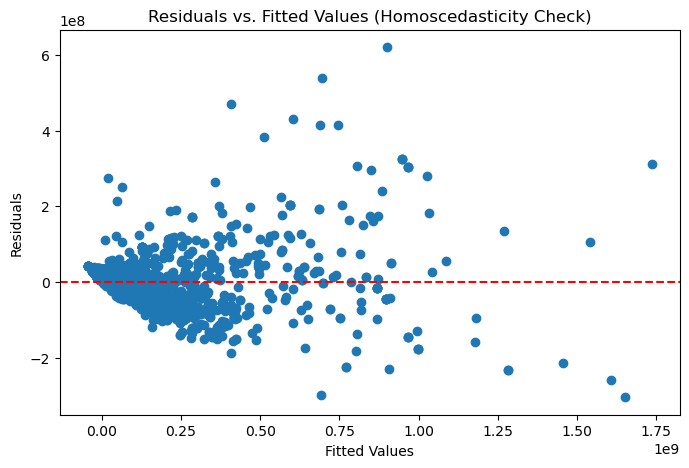

In [317]:
# 3. Homoscedasticity (Residuals vs. Fitted Values Plot) - Constant variance
plt.figure(figsize=(8, 5))
plt.scatter(model.predict(X), model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values (Homoscedasticity Check)")
plt.show()

<Figure size 800x500 with 0 Axes>

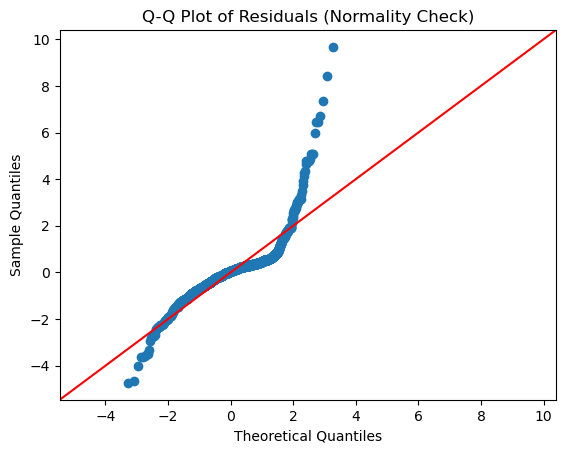

In [318]:
# 4. Normality of Errors (Q-Q plot and Shapiro-Wilk Test)
# Q-Q Plot
plt.figure(figsize=(8, 5))
sm.qqplot(model.resid, line='45', fit=True)
plt.title("Q-Q Plot of Residuals (Normality Check)")
plt.show()

In [319]:
# Shapiro-Wilk Test for normality of residuals
shapiro_test = shapiro(model.resid)
print(f'Shapiro-Wilk Test: W={shapiro_test[0]:.3f}, p-value={shapiro_test[1]:.3f}')

Shapiro-Wilk Test: W=0.804, p-value=0.000


In [320]:
# 5. Multicollinearity (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

            Variable        VIF
0              const  35.277155
1         popularity   1.575845
2       vote_average   1.122047
3  production_budget   2.153675
4   domestic_gross_y   2.024507


In [321]:
def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, threshold_out=0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval:.6}')
        
        # Backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]  # Exclude the intercept
        worst_pval = pvalues.max()  # highest p-value
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval:.6}')
        
        if not changed:
            break

    return included

# Define predictor variables and response variable
X = df[['popularity', 'vote_average', 'vote_count', 'production_budget', 'domestic_gross_y']]
y = df['roi']

# Perform stepwise selection
best_features = stepwise_selection(X, y)

# Fit the final model using the best features
X_best = sm.add_constant(X[best_features])
model = sm.OLS(y, X_best).fit()

print(model.summary())

Add  domestic_gross_y with p-value 2.18536e-09
Add  production_budget with p-value 7.08849e-32
Add  vote_average with p-value 0.0151077
Add  vote_count with p-value 0.0258641
                            OLS Regression Results                            
Dep. Variable:                    roi   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     48.40
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           7.42e-39
Time:                        11:33:09   Log-Likelihood:                -7589.3
No. Observations:                1950   AIC:                         1.519e+04
Df Residuals:                    1945   BIC:                         1.522e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std

# Data Visualizations

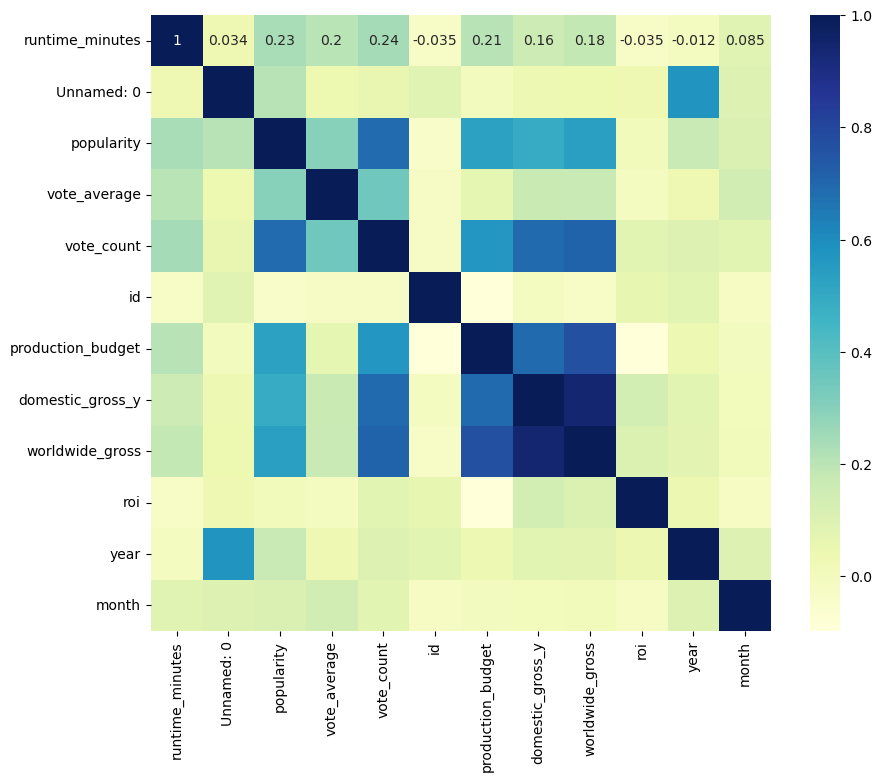

In [322]:
# Set figure size to make the plot larger
plt.figure(figsize=(10, 8))

# Plotting the correlation heatmap
dataplot = sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)

# Displaying heatmap
plt.show()

Text(0.5, 1.0, 'ScatterPlot on Correlation')

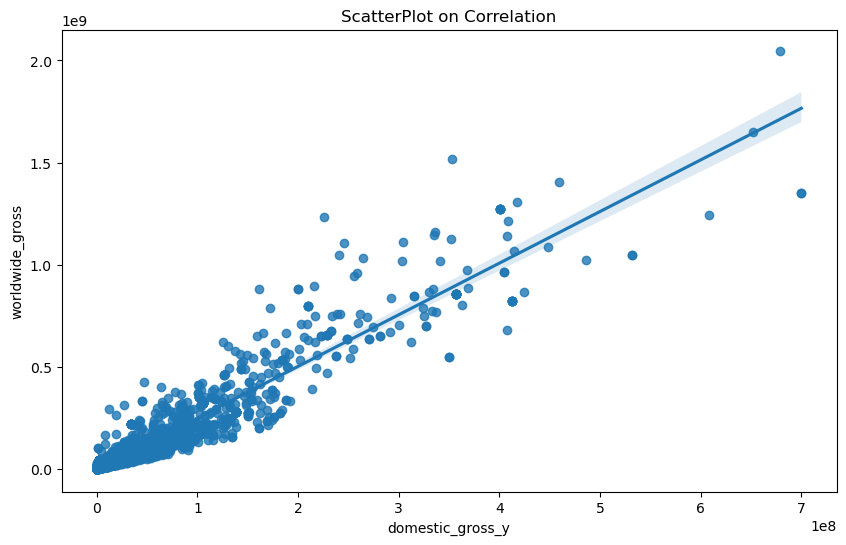

In [323]:
plt.figure(figsize = (10,6))

sns.regplot(data=df,x='domestic_gross_y',y='worldwide_gross')
plt.title('ScatterPlot on Correlation')

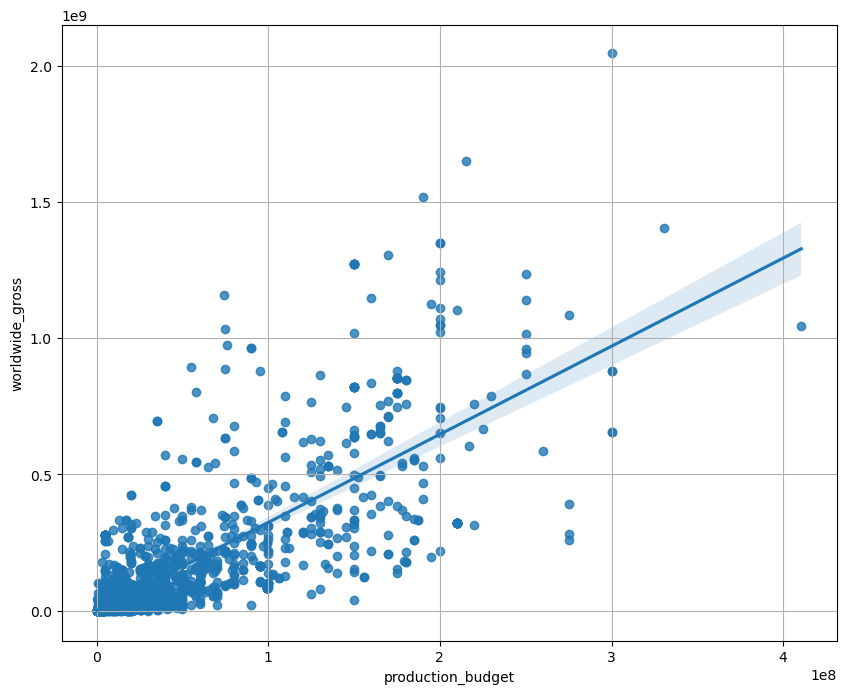

In [324]:
# Scatter plot for the budget against worlwide gross
plt.figure(figsize=(10,8))
sns.regplot(data=df,x='production_budget',y='worldwide_gross')
plt.grid()

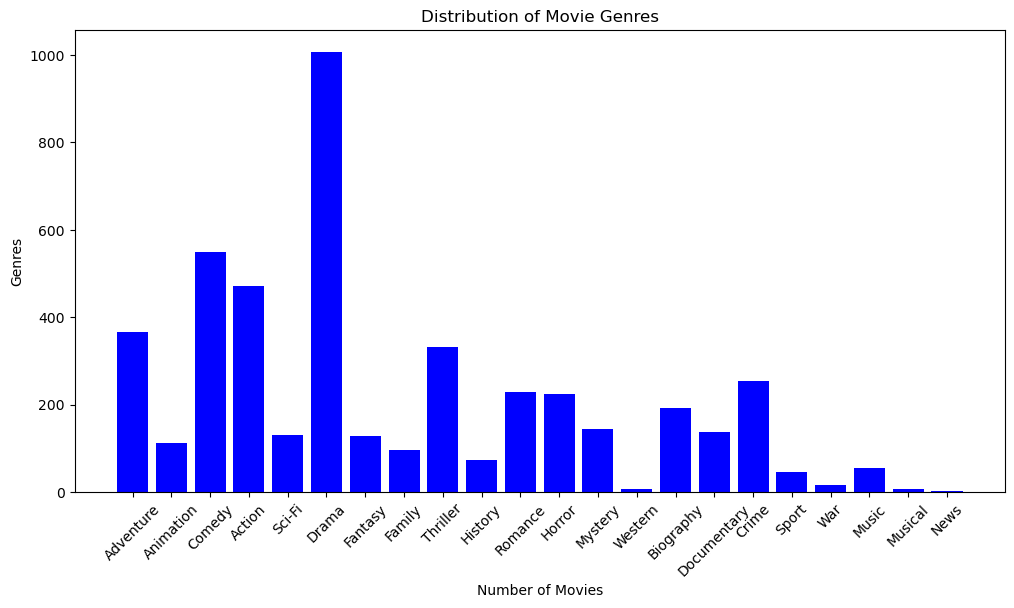

In [325]:
# Convert dictionary keys and values to lists for plotting
genres = list(genre_counts.keys())
counts = list(genre_counts.values())

# Bar plot for genre counts
plt.figure(figsize=(12, 6))
plt.bar(genres, counts, color='blue')
plt.xlabel('Number of Movies')
plt.ylabel('Genres')
plt.title('Distribution of Movie Genres')
plt.xticks(rotation=45)
plt.show()

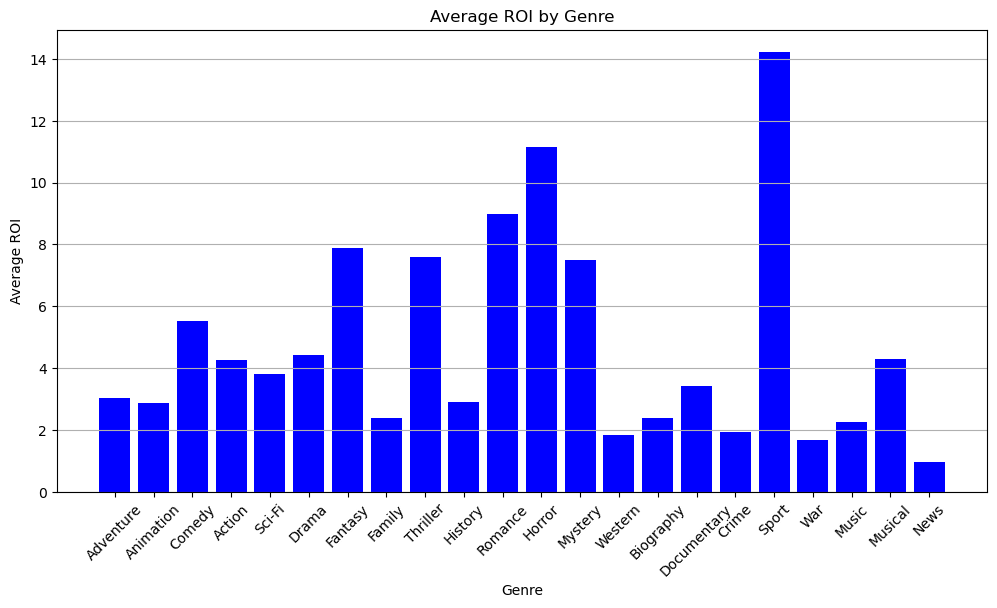

In [326]:
# Plotting
plt.figure(figsize=(12, 6))
plt.bar(transposed_df['Genre'], transposed_df['gen_avg_roi'], color='blue')
plt.title('Average ROI by Genre')
plt.xlabel('Genre')
plt.ylabel('Average ROI')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

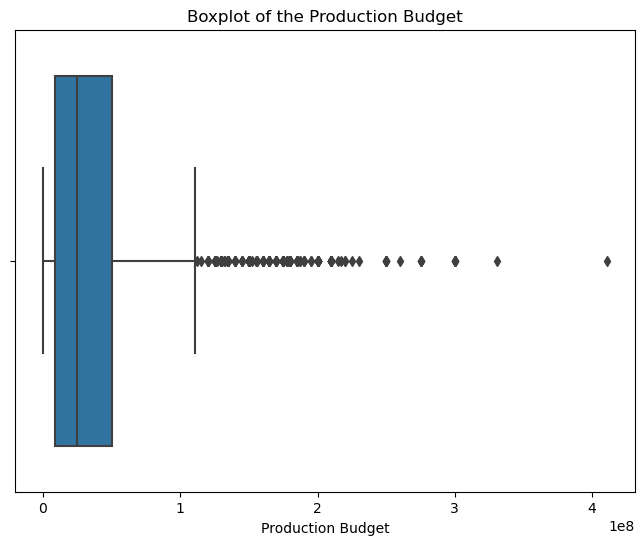

In [327]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='production_budget')
plt.xlabel('Production Budget')
plt.title('Boxplot of the Production Budget')
plt.show()

Text(0.5, 1.0, 'Distribution of the Runtime Minutes')

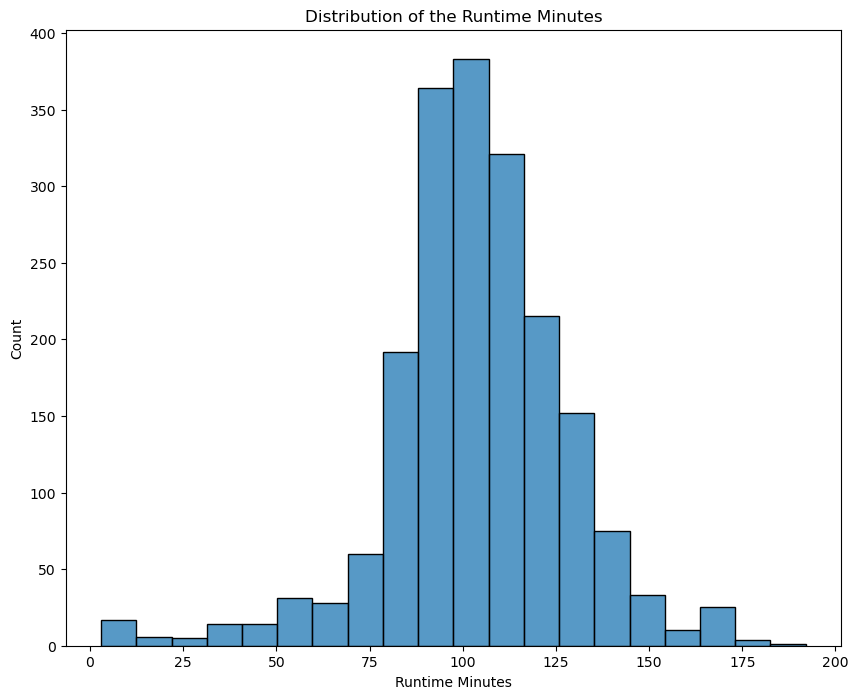

In [328]:
plt.figure(figsize=(10,8))
sns.histplot(data=df,x='runtime_minutes',bins=20)
plt.xlabel('Runtime Minutes')
plt.title('Distribution of the Runtime Minutes')

Text(0.5, 1.0, 'Distribution of the Worldwide gross')

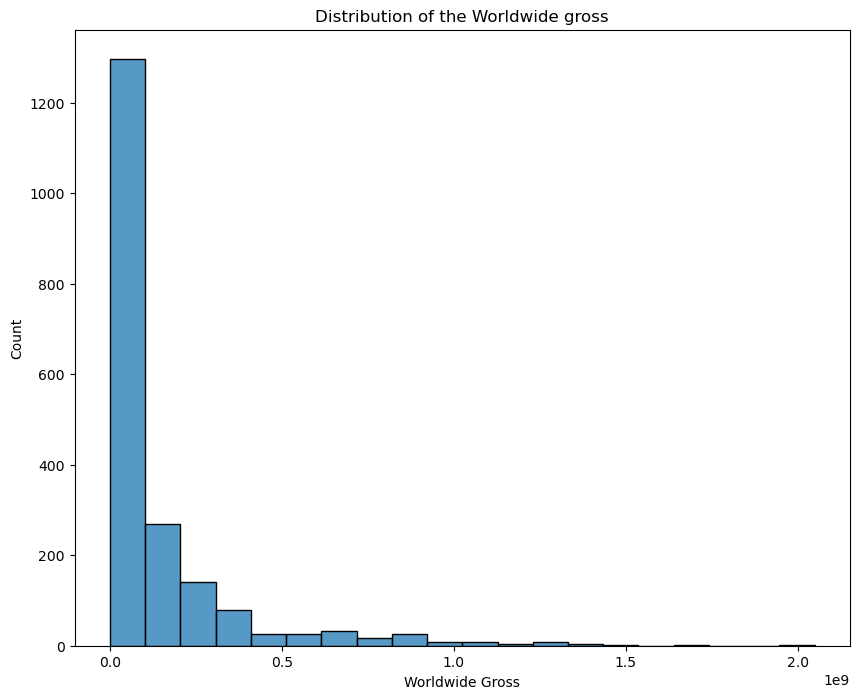

In [329]:
plt.figure(figsize=(10,8))
sns.histplot(data=df,x='worldwide_gross',bins=20)
plt.xlabel('Worldwide Gross')
plt.title('Distribution of the Worldwide gross')

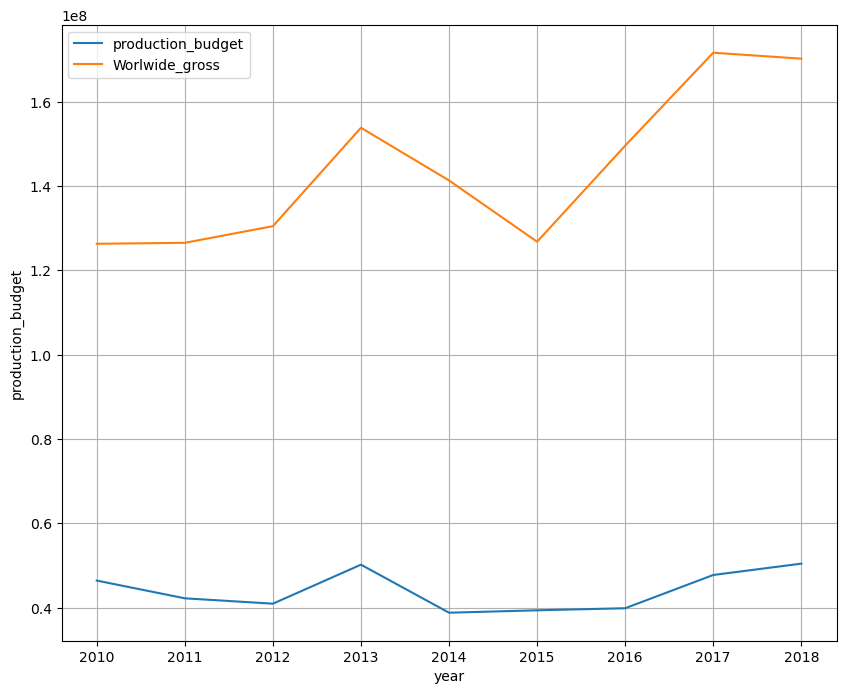

In [330]:
plt.figure(figsize=(10,8))
sns.lineplot(data=filter_data,x='year',y='production_budget',label='production_budget',ci=None)
sns.lineplot(data=filter_data,x='year',y='worldwide_gross',label='Worlwide_gross',ci=None)
# sns.lineplot()
plt.grid()

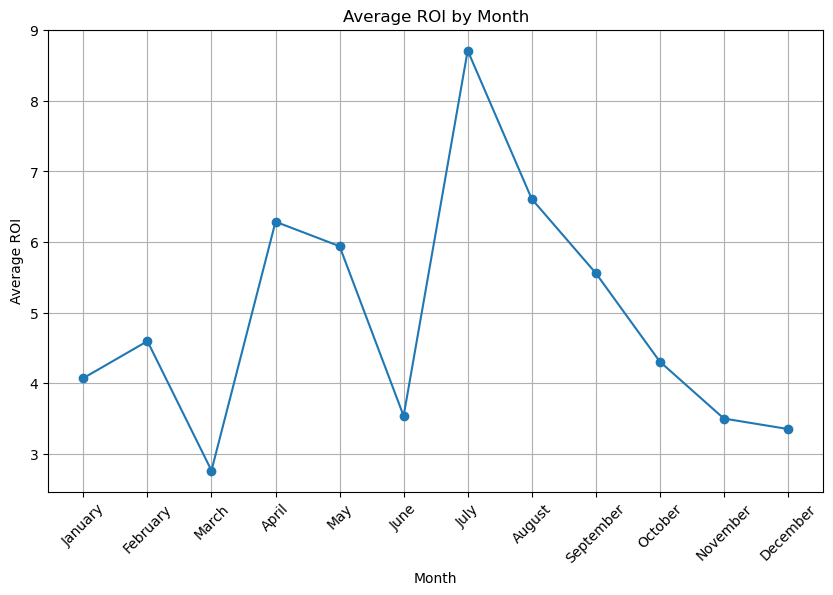

In [331]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(monthly_roi['month'], monthly_roi['roi'], marker='o')
plt.title('Average ROI by Month')
plt.xlabel('Month')
plt.ylabel('Average ROI')
plt.xticks(monthly_roi['month'], month_names[:len(monthly_roi)], rotation=45)  # Change numbers to month names
plt.grid()
plt.show()

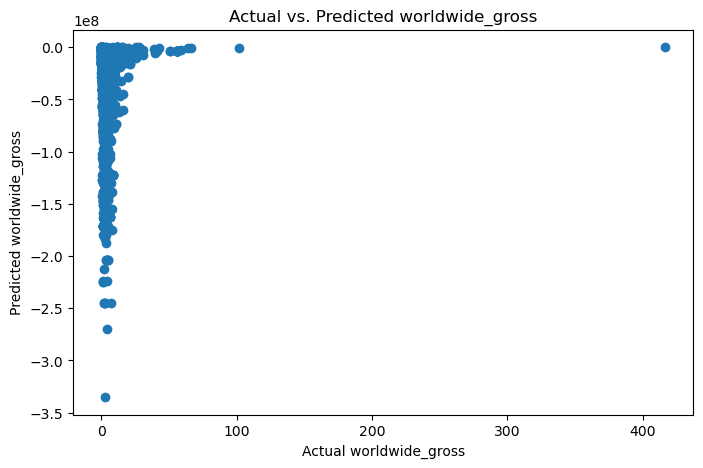

In [332]:
# 1. Linearity
# Plotting actual vs. predicted to check for linearity
plt.figure(figsize=(8, 5))
plt.scatter(y, model.predict(X))
plt.xlabel("Actual worldwide_gross")
plt.ylabel("Predicted worldwide_gross")
plt.title("Actual vs. Predicted worldwide_gross")
plt.show()

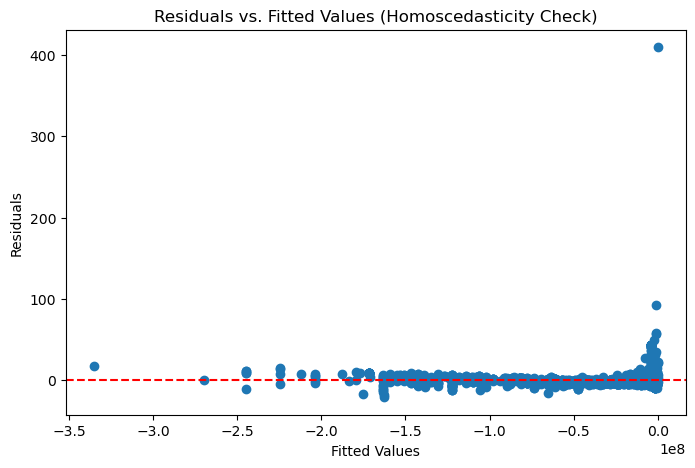

In [333]:
# 3. Homoscedasticity (Residuals vs. Fitted Values Plot) - Constant variance
plt.figure(figsize=(8, 5))
plt.scatter(model.predict(X), model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values (Homoscedasticity Check)")
plt.show()

<Figure size 800x500 with 0 Axes>

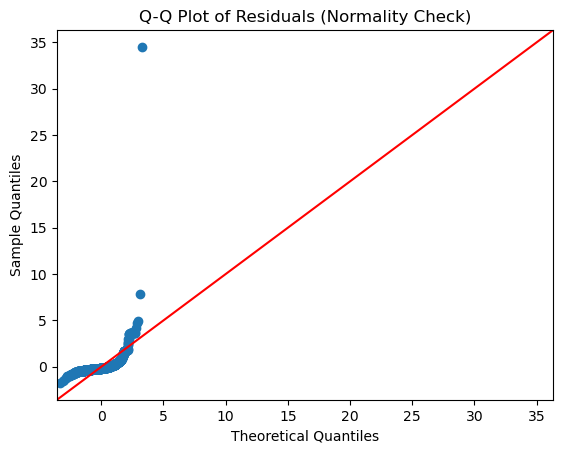

In [334]:
# 4. Normality of Errors (Q-Q plot and Shapiro-Wilk Test)
# Q-Q Plot
plt.figure(figsize=(8, 5))
sm.qqplot(model.resid, line='45', fit=True)
plt.title("Q-Q Plot of Residuals (Normality Check)")
plt.show()